# BBC News Classification Kaggle Mini-Project


In [1]:
import pandas as pd
import numpy as np


#Plots
import seaborn as sns
import matplotlib.pyplot as plt

#String Processing
import string
import re

from collections import Counter

#NLP tools
import nltk

from nltk import word_tokenize
nltk.download('punkt')

from nltk.stem.wordnet import WordNetLemmatizer
nltk.download('wordnet')

from nltk.corpus import stopwords
nltk.download('stopwords')

from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.decomposition import NMF
from sklearn.metrics import accuracy_score, confusion_matrix

from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

import itertools

[nltk_data] Downloading package punkt to C:\Users\Michael
[nltk_data]     Christensen\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Michael
[nltk_data]     Christensen\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Michael
[nltk_data]     Christensen\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Table of Contents
1. [Introduction](#introduction)
2. [Exploratory Data Analaysis](#paragraph1)
    1. [Data Inspection](#subparagraph1.1)
    2. [Data Cleaning](#subparagraph1.2)
    3. [Data Visualization](#subparagraph1.3)
3. [Building and Training Model with NMF](#paragraph2)
4. [Comparison with RF](#paragraph3)
5. [References](#references)

## 1. Introduction <a name="introduction"></a>

Our goal is to use matrix factorization to predict the category of various articles taken from BBC news. We will be performing some basic EDA and visualization, training unsupervised models using NMF, and comparing model performance with supervised methods.

https://www.kaggle.com/c/learn-ai-bbc/overview
<blockquote>
Text documents are one of the richest sources of data for businesses.

We’ll use a public dataset from the BBC comprised of 2225 articles, each labeled under one of 5 categories: business, entertainment, politics, sport or tech.

The dataset is broken into 1490 records for training and 735 for testing. The goal will be to build a system that can accurately classify previously unseen news articles into the right category.

The competition is evaluated using Accuracy as a metric.

Following blog has good information on how to look at the problem. https://cloud.google.com/blog/products/gcp/problem-solving-with-ml-automatic-document-classification
</blockquote>

## 2. Exploratory Data Analysis <a name="paragraph1"></a>

In [2]:
df_train = pd.read_csv('BBC News Train.csv')
df_test = pd.read_csv('BBC News Test.csv')

### 2.A. Data Inspection <a name="subparagraph1.1"></a>
We'll begin by taking a brief look at the data - it looks like the data has already had some processing, with the case fully adjusted to lowercase. Our training data has 1490 articles with 5 differenct categories and a unique ArticleID.

In [3]:
df_train.head()

,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business


In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  1490 non-null   int64 
 1   Text       1490 non-null   object
 2   Category   1490 non-null   object
dtypes: int64(1), object(2)
memory usage: 35.1+ KB


### 2.B. Data Cleaning and Transformation<a name="subparagraph2.2"></a>

We'll be taking the following measures to inspect and clean our data.

* Check for duplicates and omit them. Checking for duplicates makes sure we don't accidentally overrepresent articles of a particular category, which can negatively impact TF-IDF by inflating word count.
* Remove punctuation. This helps standardize the text, though we may lose some information in some cases (e.g. hyphenated words such as "content-based" shortened to "contentbased" may affect our model).
* Tokenize text for future transformation. This allows us to break down long articles into pieces to better visualize and analyze.
* Omit stopwords - these words are basically "filler" that don't always provide useful information (e.g. "the", "a", "you"). Removing this can improve model performance.
* Lemmatization. This helps standardize the text even further by grouping inflected forms of a word, such as plural words (boys --> boy) or past tense verbs (ran --> run).

In [5]:
#Check for duplicates
duplicates = df_train['Text'].duplicated()
print("Number of duplicates:", duplicates.sum())

#Drop duplicates
df_train = df_train.drop_duplicates(subset = ['Text'], keep = 'first')

Number of duplicates: 50


In [6]:
def clean(text):
    text = "".join([char if char not in string.punctuation else ' ' for char in text]) # Remove Punctuation
    text = word_tokenize(text) #Tokenize text
    stopword = set(stopwords.words('english')) # Omit Stopwords
    text = [i for i in text if i not in stopword]
    lmtz = WordNetLemmatizer()
    text = " ".join([lmtz.lemmatize(word) for word in text])
    return text
    
df_train['Text'] = df_train['Text'].apply(lambda text: clean(text))
df_test['Text'] = df_train['Text'].apply(lambda text: clean(text))

df_train.head()

,ArticleId,Text,Category
0,1833,worldcom ex bos launch defence lawyer defendin...,business
1,154,german business confidence slide german busine...,business
2,1101,bbc poll indicates economic gloom citizen majo...,business
3,1976,lifestyle governs mobile choice faster better ...,tech
4,917,enron boss 168m payout eighteen former enron d...,business


### 2.C. Data Visualization<a name="subparagraph2.3"></a>
We'll make some general observations about the data, including word count, unique word count, character length, stop word count, and a correlation plot between these features.

Taking a look at the category histogram below, we see that sports and business are slightly overrepresented compared to the other categories.

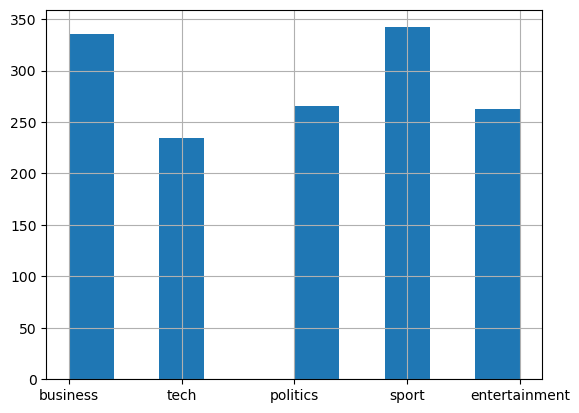

In [7]:
# Category Count
df_train['Category'].hist()
cat = ['business', 'tech', 'politics', 'sport', 'entertainment']

#### Word Count
We notice that most articles have a word count of less than 500.

<Axes: >

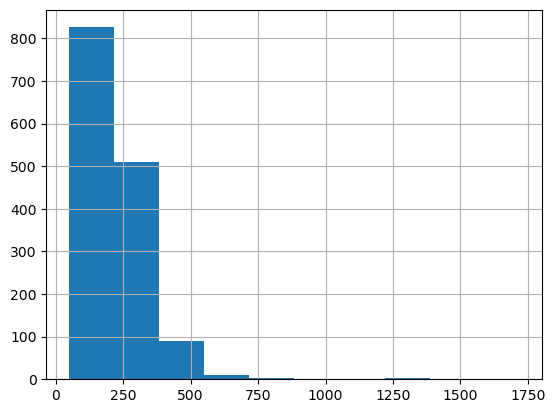

In [8]:
#Total overall wordcount
df_train['word_count'] = df_train['Text'].str.split().map(lambda x: len(x))
df_train['word_count'].hist()

#### Word Count by Category
Splitting the word count up by category, we note that the majority of sports, entertainment, and businesss articles are fairly short, while most politics and tech articles tend to skew on the long side.

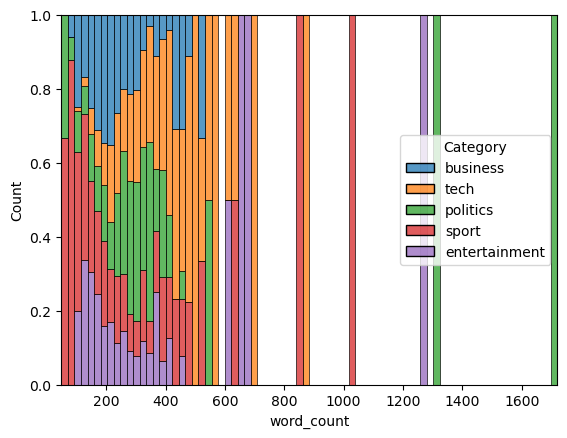

In [9]:
ax = sns.histplot(data = df_train, x = "word_count", hue = "Category", multiple = "fill")
sns.move_legend(ax, "center right")

#### Unique Word Count

We notice that the pattern holds for unique word counts as well, with most articles having a right skew with respect to word count, and with the majority of sports, entertainment, and business articles being fairly short and politics and tech skewing on the long side.

<Axes: >

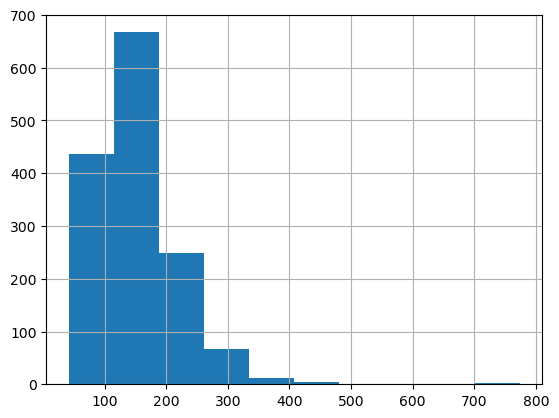

In [10]:
df_train['unique_word_count'] =df_train['Text'].apply(lambda x: len(set(str(x).split())))
df_train['unique_word_count'].hist()

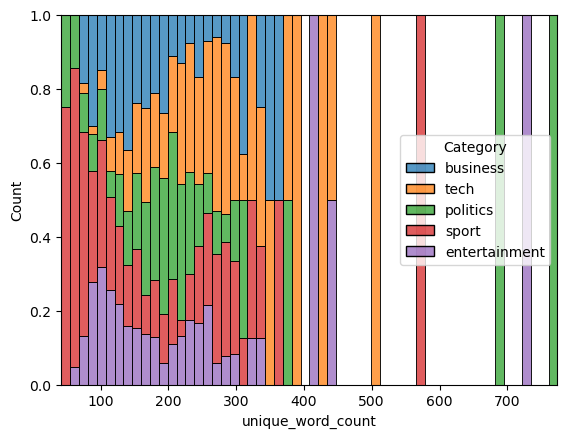

In [11]:
ax = sns.histplot(data = df_train, x = "unique_word_count", hue = "Category", multiple = "fill")
sns.move_legend(ax, "center right")

#### Character Count

<Axes: >

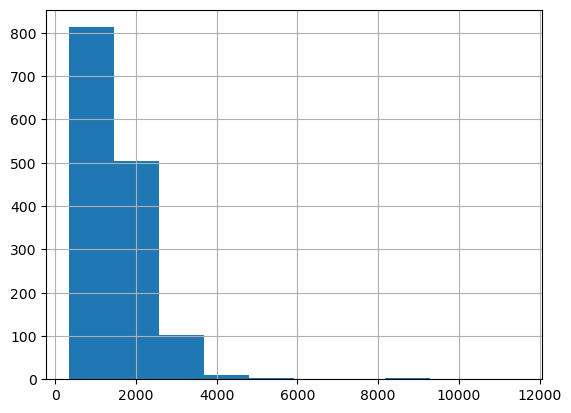

In [12]:
df_train['char_count'] =df_train['Text'].apply(len)
df_train['char_count'].hist()

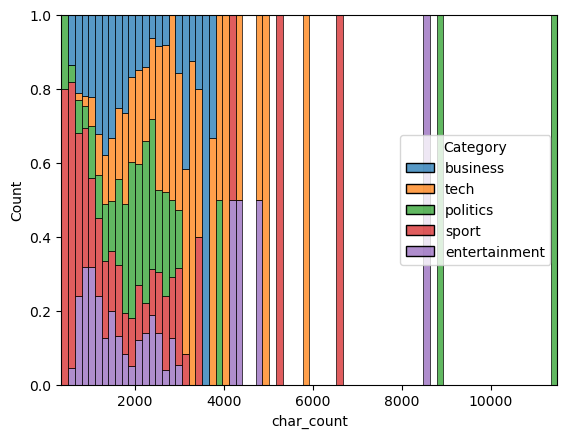

In [13]:
ax = sns.histplot(data = df_train, x = "char_count", hue = "Category", multiple = "fill")
sns.move_legend(ax, "center right")

#### Stopwords Count

<Axes: >

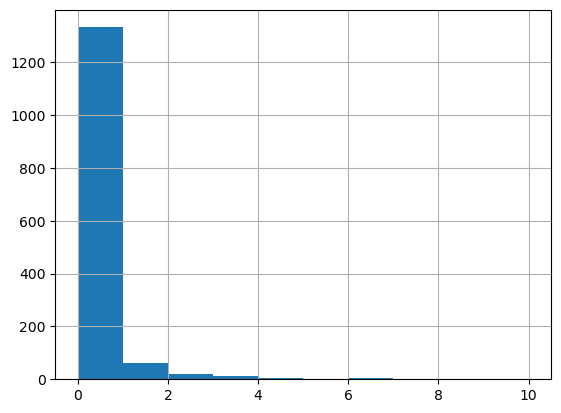

In [14]:
all_stopwords = stopwords.words('english')
df_train['stop_words']=df_train['Text'].apply(lambda x: len([words for words in str(x).lower().split() if words in all_stopwords]))
df_train['stop_words'].hist()

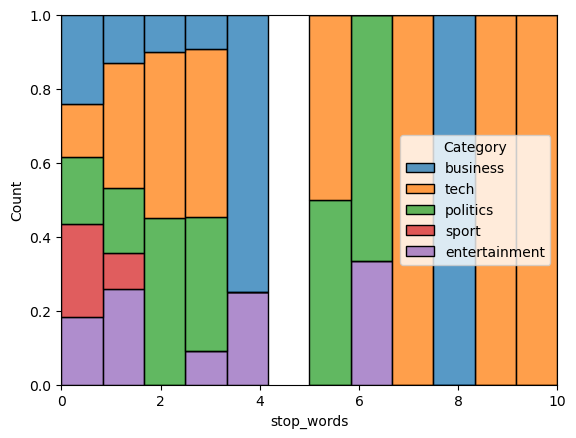

In [15]:
ax = sns.histplot(data = df_train, x = "stop_words", hue = "Category", multiple = "fill")
sns.move_legend(ax, "center right")


#### Correlation Heatmap
We can take this time to factorize our categories so we can relabel everything in the future and also to generate a correlation heatmap between our factors. Although we visually identified some differences between the categories, a correlation heatmap shows a fairly weak relationship between length metrics and article category.

In [16]:
df_train["Factor"] = pd.factorize(df_train["Category"])[0]
df_train.head()

,ArticleId,Text,Category,word_count,unique_word_count,char_count,stop_words,Factor
0,1833,worldcom ex bos launch defence lawyer defendin...,business,195,138,1393,3,0
1,154,german business confidence slide german busine...,business,209,156,1487,0,0
2,1101,bbc poll indicates economic gloom citizen majo...,business,295,193,2091,0,0
3,1976,lifestyle governs mobile choice faster better ...,tech,354,208,2341,0,1
4,917,enron boss 168m payout eighteen former enron d...,business,212,168,1555,0,0


In [17]:
cats = (list(df_train[["Category", "Factor"]].groupby("Category").mean().itertuples(name=None)))
cats = sorted([elt[::-1] for elt in cats])
print(cats)
num, cat = list(zip(*cats))

df_test.head()

[(0.0, 'business'), (1.0, 'tech'), (2.0, 'politics'), (3.0, 'sport'), (4.0, 'entertainment')]


,ArticleId,Text
0,1018,worldcom ex bos launch defence lawyer defendin...
1,1319,german business confidence slide german busine...
2,1138,bbc poll indicates economic gloom citizen majo...
3,459,lifestyle governs mobile choice faster better ...
4,1020,enron bos 168m payout eighteen former enron di...


C:\Users\Michael Christensen\AppData\Local\Temp\ipykernel_5644\3009844100.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df_train.corr()


<Axes: >

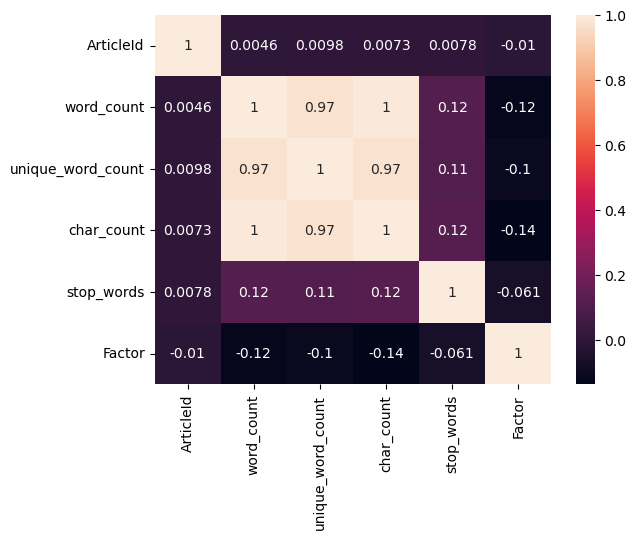

In [18]:
corr = df_train.corr()
sns.heatmap(corr, annot = True)

## 3. Building and Training a Model with NMF <a name="paragraph2"></a>

1. Vectorize our data in order to get it into matrix form.
2. Apply NMF to our vectorized data and recovering topics.
3. Measure how well the NMF model performs on the test data.
4. Change hyperparameters to adjust model performance.

In [19]:
#Vectorize and remove stopwords with sklearn
vectorizer = TfidfVectorizer(ngram_range = (1,2), 
                             sublinear_tf = True, #word frequencies are generally exponential
                             min_df = 1, #hyperparameter to check later
                             norm = 'l2',
                             encoding = 'latin-1',
                             stop_words = 'english')

corpus = df_train['Text']

X = vectorizer.fit_transform(corpus)
vocab = np.array(vectorizer.get_feature_names_out())

###  When training the unsupervised model for matrix factorization, should we include texts (word features) from the test dataset or not as the input matrix? Why or why not?

Notice that when we chose the corpus to fit our vectorizer to, we included both the train set and the test set. This is because we are assuming we that the data is unlabeled, and our algorithm is attempting to attach one to it.

We can inspect the feature matrix for the bigrams with the highest TF-IDF score.

In [20]:
feature_matrix = pd.DataFrame(X[0].T.todense(), 
                              index = vocab, 
                              columns = ["TF-IDF"])

feature_matrix = feature_matrix.sort_values("TF-IDF", ascending = False)

feature_matrix.head(10)

,TF-IDF
worldcom,0.152983
mr ebbers,0.141770
ebbers,0.139722
accounting,0.129115
cooper,0.115782
worldcom ex,0.107581
cooper said,0.101826
worldcom accounting,0.101826
andersen,0.101826
meeting mr,0.094576


### Applying NMF to Vectorized data

Our goal is to categorize new articles into one of 5 categories. Since NMF has unnamed clusters, we need to figure out which permutation of label names works for our data. We've included a helper function to test the permutatations and then apply an accuracy score to the new label.

In [21]:
nmf = NMF(n_components = 5, 
          init = 'nndsvda',
          random_state = 0)
W = nmf.fit_transform(X)
H = nmf.components_

model_labels = np.argmax(W, axis = 1) #unlabeled topics
print(model_labels)

[2 2 2 ... 2 4 4]


In [22]:
import itertools

#helper function to rearrange model list
def remap_list(labels, yp):
    label_names = list(set(yp))
    label_map = {label_names[i]:labels[i] for i in range(len(labels))}
    #print(label_map)
    return [label_map[k] for k in yp]

def label_permute_compare(ytdf,yp,n=5):
    """
    ytdf: labels dataframe object
    yp: clustering label prediction output
    Returns permuted label order and accuracy. 
    Example output: (3, 4, 1, 2, 0), 0.74 
    """
# your code here
    #convert ground truth labels to numbers
    label_names = list(set(yp))
    
    #get list of possible labels from predictor
    assert list(set(yp)) == list(set(ytdf)) #check that the label sets are the same
    assert len(ytdf) == len(yp)
    
    #permute list of labels
    label_permute = list(itertools.permutations(label_names))
    acc = 0.0
    res = []
    
    #score each permutation 
    for labels in label_permute:
        #remap label through dictionary based on permuted labels
        ypl = remap_list(labels, yp) #new permuted list via dictionary
        acc_i = round(accuracy_score(ytdf, ypl),3) #scoring new prediction
        if acc_i > acc:
            res = labels
            acc = acc_i
    
    return acc, res

In [23]:
labels = list(df_train['Factor'])
acc, labelorder = label_permute_compare(labels, model_labels)

print(labelorder, acc)

(2, 3, 0, 4, 1) 0.924


From our helper function, we have the best label order as (2,3,0,4,1) corresponding to business, tech, politics, sport, and entertainment in that order with an accuracy of 92.4%.

In [24]:
cm = confusion_matrix(labels, remap_list(labelorder, model_labels))
print(cm)

[[325   8   2   0   0]
 [  3 226   0   3   2]
 [ 23   5 232   6   0]
 [  1   0   0 339   2]
 [ 10  32   2  10 209]]


From our confusion matrix, we can see our model tends falsely classify a lot of articles as entertainment, particularly as tech.

#### Hyperparameter Tuning

We're going to do some simple hyperparameter tuning on both the vectorizer and NMF matrix and select the best performing model as our test submission. Rather than do a GridSearch, we are going to iterate through a small subset of reasonable parameters and pick the best one based on accuracy.

In [25]:
#### Hyperparameter Tuning

sublinear = [True, False]
ngrams = [(1,1), (1,2)]
nrm = ['l1', 'l2']

vparams = list(itertools.product(sublinear, ngrams, nrm))

solver = ['cd', 'mu']
beta_loss = ['frobenius', 'kullback-leibler'] #if solver = mu

nmfparams = list(itertools.product(solver, beta_loss))

acc_list = []
labellist = []
cm_arr = []
params = []

for sb, ng, nm in vparams:
    vectorizer_hp = TfidfVectorizer(ngram_range = ng, 
                                      sublinear_tf = sb, 
                                      min_df = 1, 
                                      norm = nm,
                                      encoding = 'latin-1',
                                      stop_words = 'english')
    X_new = vectorizer_hp.fit_transform(corpus)
    for sol, bl in nmfparams:
        if sol == 'mu':
            nmf_hp = NMF(n_components = 5,
                         init = 'nndsvda',
                         random_state = 0,
                         solver = sol,
                         beta_loss = bl)
        else:
            nmf_hp = NMF(n_components = 5,
                         init = 'nndsvda',
                         random_state = 0,
                         solver = sol)
        W_new = nmf_hp.fit_transform(X_new)
        
        hp_labels = list(np.argmax(W_new, axis = 1))
        acc_hp, labelorder_hp = label_permute_compare(labels, hp_labels)
        
        acc_list.append(acc_hp)
        labellist.append(labelorder_hp)
        
        hp_ypred = remap_list(labelorder_hp, hp_labels)
        cm_arr.append(confusion_matrix(labels, hp_ypred))
        params.append([sb,ng,nm,sol,bl])

In [26]:
from tabulate import tabulate
print(tabulate(sorted(list(zip(acc_list,params,labellist)),reverse = True), headers = ["acc", "params", "list"]))

  acc  params                                           list
-----  -----------------------------------------------  ---------------
0.96   [True, (1, 1), 'l1', 'mu', 'kullback-leibler']   (0, 3, 2, 4, 1)
0.956  [True, (1, 1), 'l1', 'mu', 'frobenius']          (0, 3, 2, 4, 1)
0.953  [True, (1, 1), 'l2', 'cd', 'kullback-leibler']   (1, 3, 2, 4, 0)
0.953  [True, (1, 1), 'l2', 'cd', 'frobenius']          (1, 3, 2, 4, 0)
0.949  [True, (1, 1), 'l2', 'mu', 'frobenius']          (1, 3, 2, 4, 0)
0.948  [True, (1, 1), 'l1', 'cd', 'kullback-leibler']   (0, 3, 2, 4, 1)
0.948  [True, (1, 1), 'l1', 'cd', 'frobenius']          (0, 3, 2, 4, 1)
0.942  [True, (1, 2), 'l2', 'mu', 'frobenius']          (2, 3, 0, 4, 1)
0.924  [True, (1, 2), 'l2', 'cd', 'kullback-leibler']   (2, 3, 0, 4, 1)
0.924  [True, (1, 2), 'l2', 'cd', 'frobenius']          (2, 3, 0, 4, 1)
0.924  [False, (1, 1), 'l1', 'mu', 'kullback-leibler']  (3, 2, 0, 4, 1)
0.919  [False, (1, 2), 'l1', 'mu', 'frobenius']         (3, 2, 4, 0, 1)
0.9

The best performing model had sublinear scaling, used unigrams, l1 loss, used a multiplicative update solver, and used kullback-leibler as the beta loss function.

In [27]:
accmax, parammax, labelmax, cmmax = max(zip(acc_list, params, labellist, cm_arr))

In [28]:
vectorizer_test = TfidfVectorizer(ngram_range = (1,1), 
                                  sublinear_tf = True, 
                                  min_df = 1, 
                                  norm = 'l1',
                                  encoding = 'latin-1',
                                  stop_words = 'english')

X_test = vectorizer_test.fit_transform(df_test['Text'].values.astype('U'))

nmf_test = NMF(n_components = 5,
            random_state = 0,
            solver = 'mu',
            beta_loss = "kullback-leibler")
W_test = nmf_test.fit_transform(X_test)
label_test = list(np.argmax(W_test, axis = 1))

In [29]:
label_dict = {0:'business', 3:'tech', 2:'politics', 4:'sport', 1:'entertainment'}

test_pred = pd.DataFrame(columns=['ArticleId', 'Category'])
test_pred['ArticleId'] = df_test['ArticleId']
test_pred['ypred'] = label_test
test_pred['Category'] = test_pred['ypred'].apply(lambda i: label_dict[i])
test_pred = test_pred.drop('ypred',1)
print(test_pred.head(15))

test_pred.to_csv('submission.csv', index = False)

    ArticleId       Category
0        1018  entertainment
1        1319  entertainment
2        1138  entertainment
3         459          sport
4        1020  entertainment
5          51           tech
6        2025       politics
7        1479          sport
8          27  entertainment
9         397          sport
10       1644           tech
11        263          sport
12        765  entertainment
13       2134  entertainment
14        297       politics


C:\Users\Michael Christensen\AppData\Local\Temp\ipykernel_5644\47374579.py:7: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  test_pred = test_pred.drop('ypred',1)


The test submission only had an accuracy of 17.6% despite having a fairly high training accuracy - we will have to revisit this.

# 4. Comparison with Supervised Learning (RF)
<a name="paragraph3"></a>

Let's try comparing our NMF with a Random Forest classifier. We'll use the same vectorizer we used in NMF.

In [30]:
data_X = np.array(df_train['Text'])
data_y = np.array(df_train['Category'])
data_test = np.array(df_test['Text'].values.astype('U'))

#Train Test Split
X_train, X_test, y_train, y_test = train_test_split(data_X, data_y, test_size = 0.1, random_state = 0)

In [31]:
#Vectorize X
vect = TfidfVectorizer(ngram_range = (1,1), 
                       sublinear_tf = True, 
                       min_df = 1, 
                       norm = 'l1',
                       encoding = 'latin-1',
                       stop_words = 'english')      

vect_fit = vect.fit(X_train)

X_train_v = pd.DataFrame(vect_fit.transform(X_train).toarray())
X_test_v = pd.DataFrame(vect_fit.transform(X_test).toarray())
X_test_train_v = pd.DataFrame(vect_fit.transform(data_test).toarray())

In [32]:
rf = RandomForestClassifier(n_estimators = 50, random_state = 0).fit(X_train_v, y_train)

y_pred = rf.predict(X_test_v)

print("Accuracy:", round(accuracy_score(y_pred, y_test),3))

cm = confusion_matrix(y_test, y_pred)
print(cm)

Accuracy: 0.938
[[31  0  0  0  0]
 [ 2 24  0  1  0]
 [ 2  0 25  2  0]
 [ 0  0  0 34  0]
 [ 1  1  0  0 21]]


In [33]:
rf_pred = pd.DataFrame(columns=['ArticleId', 'Category'])
rf_pred['ArticleId'] = df_test['ArticleId']
rf_pred['Category'] = rf.predict(X_test_train_v)
print(rf_pred.head(15))

test_pred.to_csv('submission_rf.csv', index = False)

    ArticleId       Category
0        1018       business
1        1319       business
2        1138       business
3         459           tech
4        1020       business
5          51          sport
6        2025          sport
7        1479  entertainment
8          27       business
9         397  entertainment
10       1644       politics
11        263  entertainment
12        765       business
13       2134       business
14        297          sport


Again we have a fairly low (~18%) accuracy on the provided test data in spite of being fairly accurate on for the training data that we split. This may be due to model overfitting. The random forest classifier seems to have a significantly faster runtime for similar results and can achieve reasonable accuracy even with a small training set.

## References: <a name="references"></a>
https://cloud.google.com/blog/products/ai-machine-learning/problem-solving-with-ml-automatic-document-classification

https://towardsdatascience.com/nlp-in-python-data-cleaning-6313a404a470

https://neptune.ai/blog/vectorization-techniques-in-nlp-guide

https://neptune.ai/blog/exploratory-data-analysis-natural-language-processing-tools

https://www.kaggle.com/code/sainathkrothapalli/beginners-approach-to-nlp-problems

https://www.kaggle.com/code/sainathkrothapalli/nlp-visualisation-guide

https://www.analyticsvidhya.com/blog/2021/06/part-15-step-by-step-guide-to-master-nlp-topic-modelling-using-nmf/

https://www.kaggle.com/code/mattison/unsupervised-matrix-factorization#%F0%9F%87%AC%F0%9F%87%A7-BBC-NEWS-CLASSIFICATION-PROJECT

https://www.kaggle.com/code/sauravmaheshkar/fake-news-classification-using-random-forest